# My financial journey


After a few years interested in the fianancial market, looking back I made a ton of mistakes and they made a better investor.

First of all, let me present myself. My name is Rafael, I am a undergraduate at University of São Paulo, studying Computer Information Systems. Working as a intern in a Asset Manegment Firm.

My journey in the financial market began with the 2018 bull market, it was the first time the Ibovespa hit 100k points and investing was becoming more accessible to the average Joe, with brokers like XP inc. offering the low fees to invest and user friendly experience to investing. Followed by this, the rise of fianancial influencer, like Thiago Nigro, also know as Primo Rico, explaning about the diverse products and how they could help the average person, not just the rich ones, to achive theirs financial goals.

You can cleary see this in the image bellow, with the vertical axis representing the amount of investors:

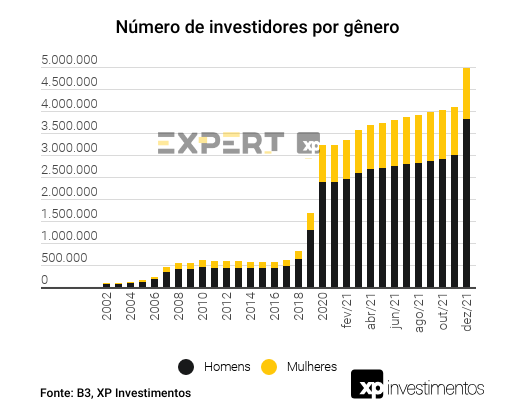

At home I also had a big influence in my dad, that always incentivise me and my brother to save money. His biggest incentive was the allowence he gave us, but it had a bonus, every end of the month it would compound 10%, giving us the idea of money in time.

During this time, I was in high school and a few friends of mine began to talk about making money in the market, also during that time the Youtube algorithm began to promote a lot of content related to finance. That made me research investing methods that would make the biggest amount of money in the least amount of time. 

With that goal in mind, i found technical analysis, with the two most prommissing tecniques been, moving averages and momentum investing. In this article i plan to discuss how these technics work and if they can produce results to the average person.

## Simple double moving averages investing

Moving averages trading is a technical analysis tool the involves two moving averages of a time-series, one long, signifing the longer term trend in the asset, and one short, signifing the short term trend. When the short term trend is above the long term one, the market is signaling a upward trend, so it's a buy signal. The oposite is true, when the long term trend is above the short term one, the market is in a downward trend.

The mathematical formula for the moving averages at a given time $t$:

$$
\begin{align}
a_{L, t} = \frac{1}{L}\sum^{L}_{j=1}p_{t - L + j} && a_{s, t} = \frac{1}{S}\sum^{S}_{j=1}p_{t - S + j}
\end{align}
$$

With $L$ being the long period, and $S$ being the short. To identify if the time $t$ is a buy, sell signal or neutral signal, we use the following ratio:

$$
R_t = \frac{a_{S, t} - a_{L, t}}{a_{L, t}}
$$

And the classification process, goes as following:
$$
Signal_t = 
\begin{aligned}
\begin{cases}
Buy: && R_t \gt B \\ 
Neutral: && -B \le R_t \le B \\
Sell: && R_t \lt -B
\end{cases}
\end{aligned}
$$

B is the bandwith of trading, if it's 0 every day you have a trading position.

Below a code that implements a simple moving average algorithm.

<Axes: xlabel='Date'>

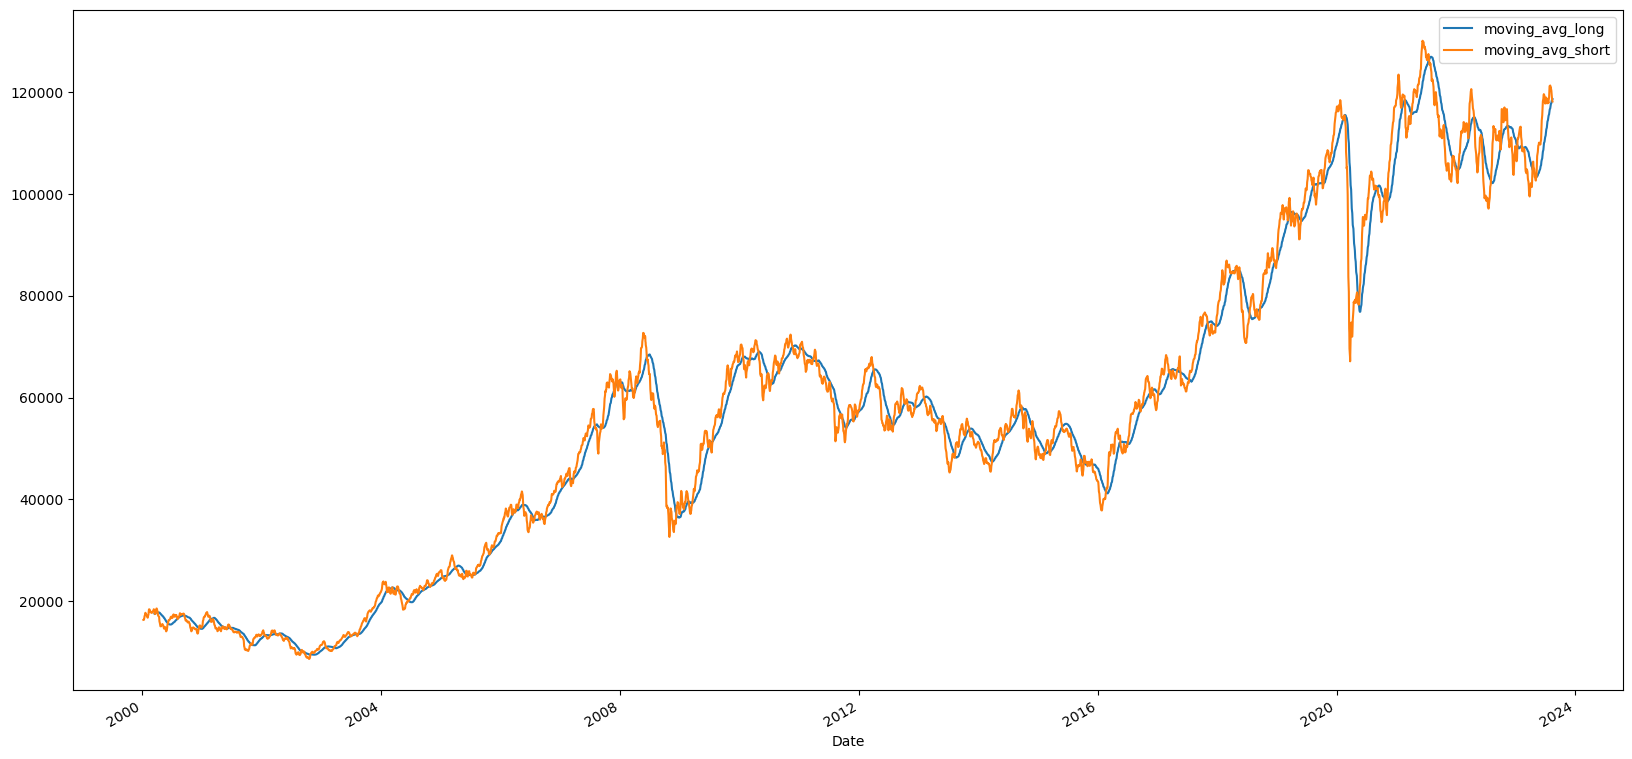

In [139]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

def moving_avg(time_serie: pd.Series, 
               period_long: int, 
               period_short: int,
               b: float = 0):
    df = time_serie.to_frame()
    df["moving_avg_long"] = time_serie.rolling(window=period_long).mean()
    df["moving_avg_short"] = time_serie.rolling(window=period_short).mean()
    df["ratio"] = (df["moving_avg_short"] - df["moving_avg_long"])/df["moving_avg_long"]
    def signal(x, b):
        if x > b:
            return 2
        elif x < -b:
            return 0
        else:
            return 1
    df["signal"] = df["ratio"].apply(signal, b=b)
    return df
web = yf.Ticker("^BVSP")
df = web.history(start=datetime.datetime(2000, 1, 1))["Close"]
series = moving_avg(df, 50, 5)
series[["moving_avg_long", "moving_avg_short"]].plot.line(figsize=(20, 10))

The algorithm is simple, using rolling windows to calculate the average for each time step and returning a dataframe with the averages and the classification for each period, with 2 being a buy signal, a 1 being a neutral position and a 0 a sell signal. Now that we have a working algorithm we can calculate if it generate profit or loss.

In [140]:
def returns_moving_averages(df: pd.DataFrame) -> dict:
    df.dropna(inplace=True)
    returns_buy = np.array([])
    returns_sell = np.array([])
    last = None
    for ind, row in enumerate(df.to_dict("records")):
        if last is None:
            last = (row["signal"], row["Close"])
            continue
        if row["signal"] != last[0]:
            if last[0] == 2:
                returns_buy = np.append(returns_buy,  df.iloc[ind-1, 0]/last[1])
            elif last[0] == 0:
                returns_sell = np.append(returns_sell, last[1]/df.iloc[ind-1, 0])
            last = (row["signal"], row["Close"])
    return {"return total": np.nanprod(np.append(returns_buy, returns_sell)),
            "volatility total": np.nanstd(np.append(returns_buy, returns_sell)),
            "return buy signal": np.nanprod(returns_buy),
            "volatility buy signal": np.nanstd(returns_buy),
            "return sell signal": np.nanprod(returns_sell),
            "volatility sell signal": np.nanstd(returns_sell),
            "asset returns": df["Close"][-1]/df["Close"][0],
            "return array buy signal": returns_buy,
            "return array sell signal": returns_sell}
    

This simple function calcuate the profit or loss, for the total of opertions and for each kind of operation.

In [141]:
results = returns_moving_averages(series)
print(f"The returns of the buy and sell signals {round((results['return total'] - 1)*100, 2)}%")
print(f"The returns of the buy signals {round((results['return buy signal'] - 1)*100, 2)}%")
print(f"The returns of the sell signals {round((results['return sell signal'] - 1)*100, 2)}%")
print(f"The market return was {round((df[-1]/df[0] - 1)*100, 2)}%")

The returns of the buy and sell signals 4190.34%
The returns of the buy signals 1484.87%
The returns of the sell signals 170.71%
The market return was 591.5%


As you can see we got really good, 8 times the results of the market. And that was what really caught my eyes in the beggining of the journey, it was almost magical, in 20 years you could multiply your money by 42 fold, while the market "only" gave almost 7 times. But maybe that was luck, lets try a wide range of parameters and windows of returns to see if this strategy still holds true

In [142]:
def backtest(time_series, folds_series=5, long_window = (50, 100, 5), short_window = (1, 10, 5), b_range=(0, 0.05, 5)):
    """
    Recives a time series as input an compute the moving averages for combintions of periods. Return a DataFrame with returns, volatility and market information. 
    The index describe the iteration with the structure (long window, short window, b, period)
    
    The parameters [long_window, short_window, b_range], follow the patern (start, stop, num).
    
    Parameter
    """
    data = pd.DataFrame([])
    folds = [df.iloc[int((i/folds_series)*df.shape[0]):int(((i+1)/folds_series)*df.shape[0])] for i in range(folds_series)]
    for num, fold in enumerate(folds):
        for long in np.linspace(start=long_window[0], stop=long_window[1], num=long_window[2], dtype=int):
            for short in np.linspace(start=short_window[0], stop=short_window[1], num=short_window[2], dtype=int):
                for b in np.linspace(start=b_range[0], stop=b_range[1], num=b_range[2], dtype=float):
                    results = returns_moving_averages(moving_avg(fold, long, short, b))
                    data = pd.concat([data, pd.DataFrame([(results['return total'] - 1)*100,
                                                          (results["asset returns"] - 1)*100, 
                                                          (results['return buy signal'] - 1)*100, 
                                                          (results['return sell signal'] - 1)*100,
                                                          (results['volatility total'])*100,
                                                          (results['volatility buy signal'])*100, 
                                                          (results['volatility sell signal'])*100], 
                                                         index=["Returns Total", "Asset Return", "Returns Buy Signal", "Returns Sell Signal", "Volatility Total", "Volatility Buy", "Volatility Sell"], 
                                                         columns=[f"{long}, {short}, {b}, {fold.index[0].strftime('%Y-%m')}-{fold.index[-1].strftime('%Y-%m')}"]).T], axis=0) #Adicionar o periodo
    return data
                

In [143]:
backtest_results = backtest(df, folds_series=10)

<Axes: >

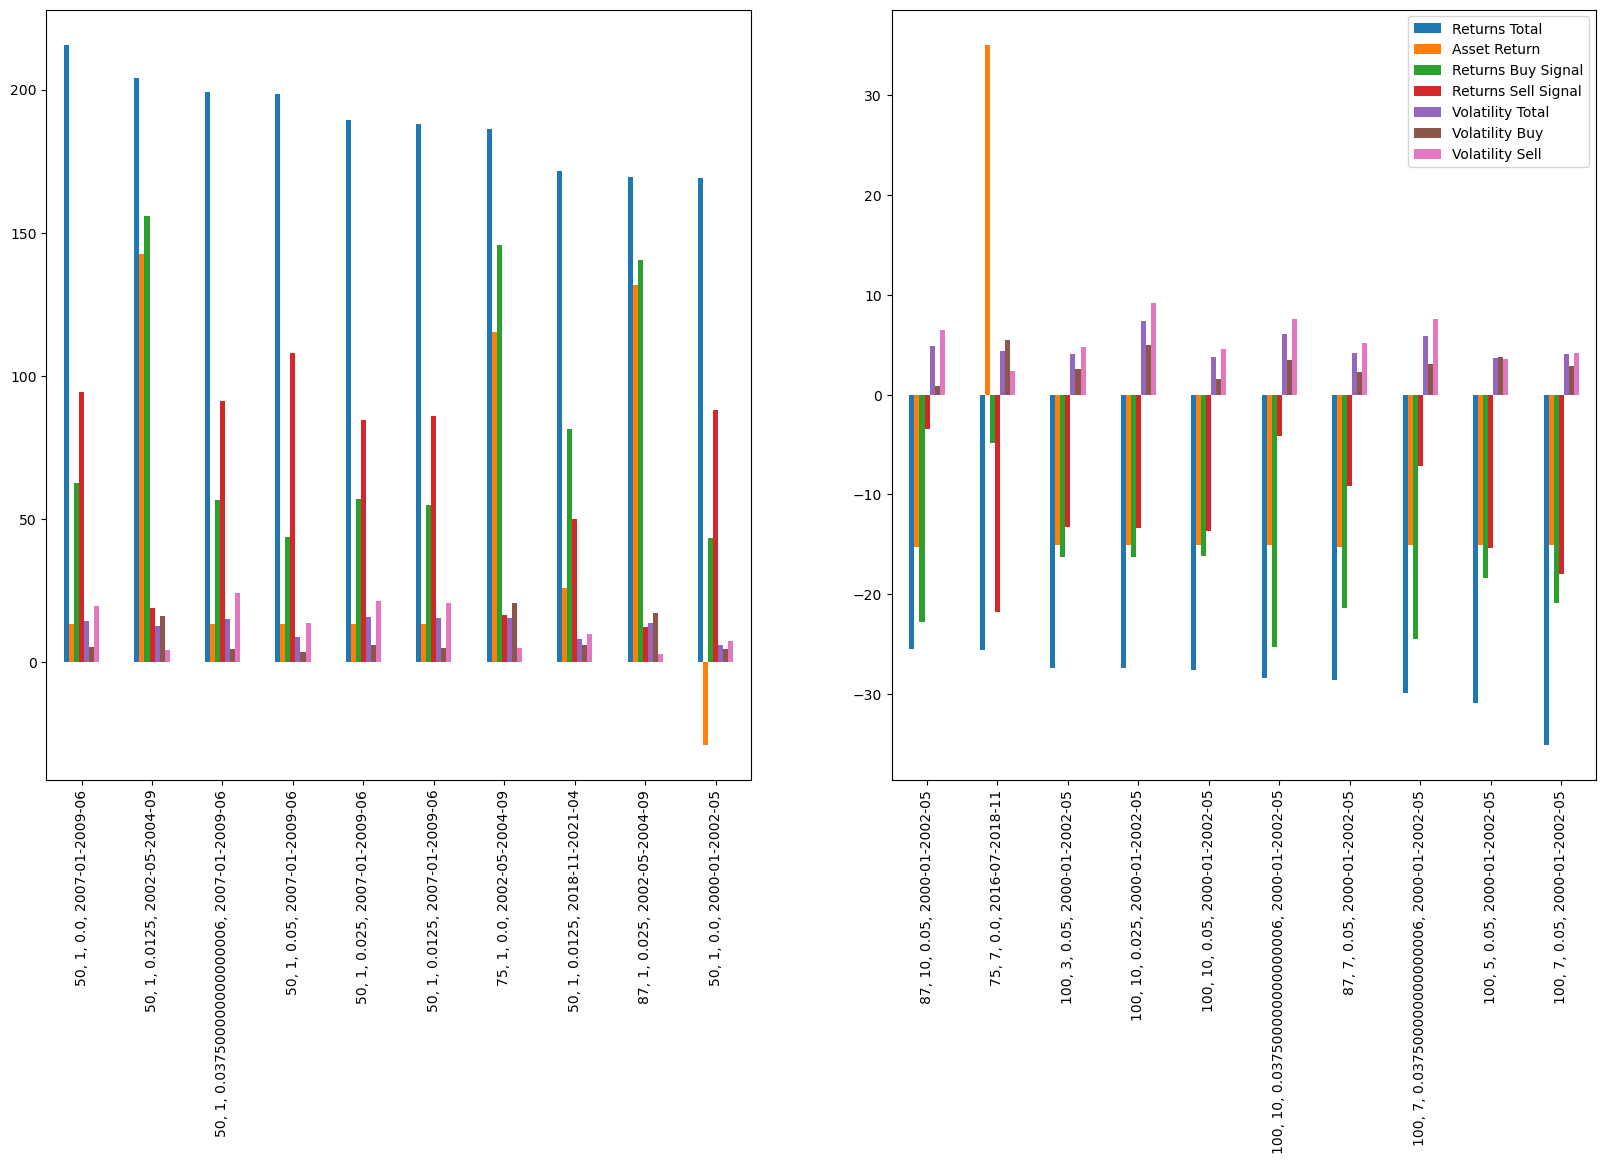

In [144]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
backtest_results.sort_values("Returns Total", ascending=False).tail(10).plot.bar(ax=ax[1])
backtest_results.sort_values("Returns Total", ascending=False).head(10).plot.bar(ax=ax[0], legend=False)

In [123]:
backtest_results.describe()

,Returns Total,Asset Return,Returns Buy Signal,Returns Sell Signal,Volatility Total,Volatility Buy,Volatility Sell
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,28.821426,21.975680,19.766133,8.112970,7.708342,6.570699,6.344208
std,38.700615,47.672444,30.781898,19.994318,5.665135,6.648267,6.753572
min,-35.071422,-30.695847,-25.325960,-37.545809,1.280111,0.047172,0.000000
25%,1.912732,-8.930347,-0.965514,-5.782214,3.917239,2.645021,2.433255
50%,17.945278,3.414026,11.283306,4.040820,5.382301,4.326305,4.129572
75%,47.971503,40.080236,31.970072,18.788746,10.906787,6.768374,6.870112
max,215.720141,142.421612,155.786351,107.838301,41.087145,47.953832,40.880641


Everything always looks amazing, only in the worst case scenario you get results that are worst to the market. On average you are getting 3.5% more returns, per period and on the best cases you get 50% more returns. It seems like you beat the market and não it's just wait and retire early. But as my father always told me, "there is no free launch". At the time i didn't care about transaction costs and taxes and that was the catch. If a strategy so good and so easily distributed, the market is efficient enought to precify it, so it becomes not profitable in relation to the risk-free rate, this was demonstraded by XXX (Taylor).